In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch
from utils import ops_data as data
from msfnn import MsFNN


import deepxde.optimizers
deepxde.optimizers.LBFGS_options['maxiter'] = 75_000

torch.backends.cuda.matmul.allow_tf32 = False

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
geom = dde.geometry.TimeDomain(data.time[0], data.time[-1])


def ode(x, y):
    xi = x.permute((1, 0))

    u_hat_real = y[:, [0,2,4,6]].permute((1, 0))
    u_hat_imag = y[:, [1,3,5,7]].permute((1, 0))

    residual_real = (
        data.TORCH_K @ u_hat_real
        + 2 * np.pi * -data.TORCH_C @ (u_hat_imag * xi)
        - 4 * np.pi**2 * data.TORCH_M @ (u_hat_real * xi**2)
        - data.get_force_spectral_tensor(xi.squeeze())[0].permute((1, 0))
    )

    residual_imag = (
        data.TORCH_K @ u_hat_imag
        + 2 * np.pi * data.TORCH_C @ (u_hat_real * xi)
        - 4 * np.pi**2 * data.TORCH_M @ (u_hat_imag * xi**2)
        - data.get_force_spectral_tensor(xi.squeeze())[1].permute((1, 0))
    )

    residual = residual_real + residual_imag
    return residual.permute((1, 0))


bc1 = dde.icbc.PointSetBC(
    data.xi.reshape(-1, 1), data.u_hat[0].real.reshape(-1, 1), component=0
)
bc2 = dde.icbc.PointSetBC(
    data.xi.reshape(-1, 1), data.u_hat[0].imag.reshape(-1, 1), component=1
)
bc3 = dde.icbc.PointSetBC(
    data.xi.reshape(-1, 1), data.u_hat[1].real.reshape(-1, 1), component=2
)
bc4 = dde.icbc.PointSetBC(
    data.xi.reshape(-1, 1), data.u_hat[1].imag.reshape(-1, 1), component=3
)


def ref_solution(xi):
    idx = data.xi.argsort()

    sol = [
        np.hstack(
            [
                np.interp(xi, data.xi[idx], data.u_hat[dim, idx].real).reshape(-1, 1),
                np.interp(xi, data.xi[idx], data.u_hat[dim, idx].imag).reshape(-1, 1),
            ]
        )
        for dim in range(4)
    ]
    return np.hstack(sol)


dde_data = dde.data.PDE(
    geometry=geom,
    pde=ode,
    bcs=[bc1, bc2, bc3, bc4],
    num_boundary=2,
    num_domain=1000,
    num_test=100,
    solution=ref_solution,
)

layer_size = [1] + [50] * 3 + [8]
activation = "tanh"
initializer = "Glorot uniform"
net = MsFNN(layer_size, activation, initializer, [1, 20, 50])

model = dde.Model(dde_data, net)
model.compile(
    "adam", lr=1e-3, loss_weights=[1e-5, 1, 1, 1, 1], metrics=["l2 relative error"]
)
losshistory, train_state = model.train(iterations=500000)

Compiling model...
'compile' took 0.000193 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.18e+10, 3.87e-01, 2.99e-01, 3.35e-01, 3.83e-01]    [1.20e+10, 3.87e-01, 2.99e-01, 3.35e-01, 3.83e-01]    [1.76e+01]    
1000      [2.38e+06, 2.58e-01, 2.40e-01, 1.82e-01, 2.92e-01]    [2.36e+06, 2.58e-01, 2.40e-01, 1.82e-01, 2.92e-01]    [1.39e+01]    
2000      [5.74e+05, 2.46e-01, 2.31e-01, 1.79e-01, 2.80e-01]    [5.50e+05, 2.46e-01, 2.31e-01, 1.79e-01, 2.80e-01]    [1.36e+01]    
3000      [2.52e+05, 2.37e-01, 2.23e-01, 1.78e-01, 2.75e-01]    [2.54e+05, 2.37e-01, 2.23e-01, 1.78e-01, 2.75e-01]    [1.34e+01]    
4000      [1.43e+05, 2.30e-01, 2.17e-01, 1.78e-01, 2.71e-01]    [1.49e+05, 2.30e-01, 2.17e-01, 1.78e-01, 2.71e-01]    [1.33e+01]    
5000      [9.05e+04, 2.22e-01, 2.11e-01, 1.78e-01, 2.63e-01]    [9.63e+04, 2.22e-01, 2.11e-01, 1.78e-01, 2.63e-01]    [1.31e+01]    
6000

KeyboardInterrupt: 

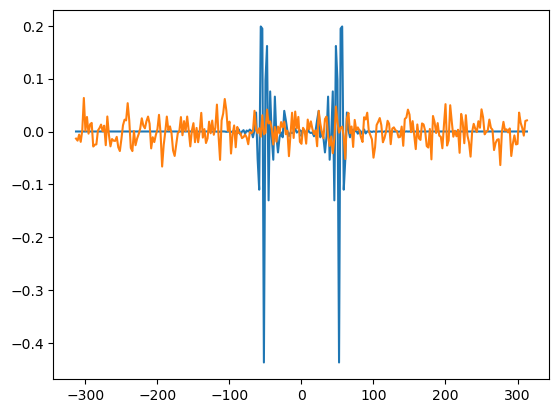

In [3]:
idx = data.xi.argsort()
plt.plot(data.xi[idx], data.u_hat[3, idx].real)
plt.plot(data.xi[idx], model.predict(data.xi[idx].reshape(-1, 1))[:, 3])